In [1]:
import numpy as np

from implementations import *
from proj1_helpers import *

In [2]:
# Load data
DATA_TRAIN_PATH = 'train.csv' 
y, tX, ids, headers = load_csv_data(DATA_TRAIN_PATH) # Modified the load_csv_data to also give headers

In [3]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [4]:
def cv_model(tX, headers, y, degree, tX_test, y_test, headers_test):
    # process features for to train the model
    data, targets, ids = process_features_train(tX, headers, y, degree)
    
    # train base model 
    w_1 = logistic_regression_demo(targets[0], data[0], max_iters=10000, gamma=0.01)

    # train jet=1 model using base model weights as initial weights
    w_2 = logistic_regression_demo_winit(targets[2], data[2], w_1, max_iters=10000, gamma=0.01)

    # train jet=2/3 model using base model weights as initial weights
    w_3 = logistic_regression_demo_winit(targets[3], data[4], w_1, max_iters=10000, gamma=0.01)
    
    

    # process test set
    data, targets, ids = process_features_train(tX_test, headers, y_test, degree)

    # create Predictions
    weights = [w_1, w_2, w_3]
    #y_pred_final = create_predictions(weights, data, ids)
    
    # calcualte the loss, but first calculate the predictions for the loss (0 1 type)
    pred_loss = create_predictions_loss(weights, data, ids)
    
    loss = calculate_loss_lr_model(targets[0], pred_loss)
    
    # map the predictions into -1 and 1
    y_pred_final = pred_loss.copy()
    y_pred_final[np.where(y_pred_final <= 0.5)] = -1
    y_pred_final[np.where(y_pred_final > 0.5)] = 1
    
    acc = np.sum(y_pred_final.T==y_test)/len(y_test)
    
    
    return loss, acc

In [5]:
def cross_validation(y, x, ids, degrees):
    seed = 1
    k_fold = 4
    
    
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    loss = np.zeros((degrees, k_fold))
    accuracy = np.zeros((degrees, k_fold))
    
    
    for degree in np.arange(degrees)+1:
        loss_d = []
        acc_d = []
        for k in range(k_fold):
            #****************************************************
            # Form train and test sets
            x_tr = x[k_indices[np.arange(len(k_indices))!=k].ravel()]
            x_te = x[k_indices[k]]

            y_tr = y[k_indices[np.arange(len(k_indices))!=k].ravel()]
            y_te = y[k_indices[k]]

            ids_tr = ids[k_indices[np.arange(len(k_indices))!=k].ravel()]
            ids_te = ids[k_indices[k]]

            print("Fold number: {f}, polynomial degree: {d}".format(f=k+1, d=degree))

            #****************************************************

            lo, acc = cv_model(x_tr, headers, y_tr, degree, x_te, y_te, headers)
            
            loss_d.append(lo[0])
            acc_d.append(acc)
        loss[degree-1] = np.array(loss_d)
        accuracy[degree-1] = np.array(acc_d)
    
    return loss, accuracy

In [6]:
degrees = 5
loss, accuracy = cross_validation(y, tX, ids, degrees)

Fold number: 1, polynomial degree: 1
Proportion test error:  [0.26202667]
Proportion test error:  [0.30562011]
Proportion test error:  [0.26332202]
Fold number: 2, polynomial degree: 1
Proportion test error:  [0.26034667]
Proportion test error:  [0.29627404]
Proportion test error:  [0.27844146]
Fold number: 3, polynomial degree: 1
Proportion test error:  [0.26413333]
Proportion test error:  [0.29993986]
Proportion test error:  [0.27043967]
Fold number: 4, polynomial degree: 1
Proportion test error:  [0.27648]
Proportion test error:  [0.29297883]
Proportion test error:  [0.26879647]
Fold number: 1, polynomial degree: 2
Proportion test error:  [0.246]
Proportion test error:  [0.24873053]
Proportion test error:  [0.23635697]
Fold number: 2, polynomial degree: 2
Proportion test error:  [0.24432]
Proportion test error:  [0.25970124]
Proportion test error:  [0.24205109]
Fold number: 3, polynomial degree: 2
Proportion test error:  [0.24485333]
Proportion test error:  [0.25302861]
Proportion t

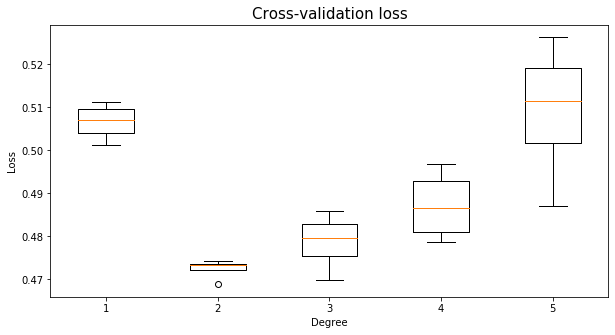

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 5))
ax = plt.boxplot(loss.T)
plt.xlabel("Degree")
plt.ylabel("Loss")
plt.title("Cross-validation loss", fontsize=15)
plt.savefig("cross_validation_loss");

In [19]:
np.savetxt("cv_accuracy.csv", accuracy, delimiter=",")
np.savetxt("cv_loss.csv", loss, delimiter=",")